[View in Colaboratory](https://colab.research.google.com/github/jeffreyrnorton/MachineLearningNotes/blob/master/RadialBasisFunctionNetwork.ipynb)

# Radial Basis Functions and Feed Forward Networks

Radial basis function networks are *not* feed forward networks.  Feed forward networks are typically used for classification whereas radial bases function networks are used for *fitting* contiguous functions.

In the case shown here, we will generate curve fits for functions.

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

Using TensorFlow backend.


RBFs are really designed to work with continuous functions.  So one problem to consider is fitting (continuous) datasets.  For simplicity - we can simply just generate a dataset using some curve function like sin.  What's nice about using a real function is that we can generate what should be other data points with ease and test concepts like forcasting (predicting out of the original training range).

In [0]:
# Generate a data set from the function sin(2*pi*t)
# Take the test set to be from -1 to 1 on 0.1
ptrain_X = np.arange(-1.0, 1.0, 0.05)
ptrain_Y = np.sin(2*math.pi*ptrain_X)

# And for validation, let's create a somewhat overlapping
# dataset, but are going to let this dataset range go to 2.
ptest_X = np.arange(0.025, 2.025, 0.05)
ptest_Y = np.sin(2*math.pi*ptest_X)

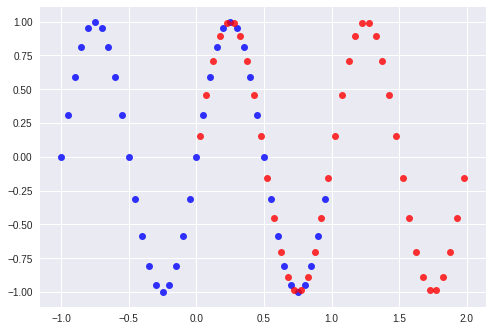

In [3]:
sns.set(style="darkgrid")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.regplot(x=ptrain_X, y=ptrain_Y, fit_reg=False, color='blue')
ax = sns.regplot(x=ptest_X, y=ptest_Y, fit_reg=False, color='red')

In [0]:
# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

Keras doesn't provide RBF layers natively.  [Petra Vidnerova](https://github.com/PetraVidnerova/rbf_keras) does provide an RBF layer - this shows how to write custom layers in Keras.

In [0]:
from keras.initializers import Initializer
import numpy as np 

class InitFromFile(Initializer):
    """ Initialize the weights by loading from file.
    # Arguments
        filename: name of file, should by .npy file 
    """
    def __init__(self, filename):
        self.filename = filename 

    def __call__(self, shape, dtype=None):
        with open(self.filename, "rb") as f:
            X = np.load(f)
        assert shape == X.shape 
        return X 

    def get_config(self):
        return {
            'filename': self.filename
        }

In [0]:
import random 
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Orthogonal, Constant
import numpy as np

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows 
          are taken as centers)
    """
    def __init__(self, X):
        self.X = X 

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx,:]

        
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units. 
    # Example
 
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X), 
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas 
    """
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas 
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
            #self.initializer = Orthogonal()
        else:
            self.initializer = initializer 
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.centers = self.add_weight(name='centers', 
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_betas),
                                     #initializer='ones',
                                     trainable=True)
            
        super(RBFLayer, self).build(input_shape)  

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp( -self.betas * K.sum(H**2, axis=1))
        
        #C = self.centers[np.newaxis, :, :]
        #X = x[:, np.newaxis, :]

        #diffnorm = K.sum((C-X)**2, axis=-1)
        #ret = K.exp( - self.betas * diffnorm)
        #return ret 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

End of Petra's code.

Similar to our feed forward case, we write some helper functions.  First ```run_model``` will create a RBFN and fit it and calculate the fitting metrics (RMSE).

In [0]:
def run_model(X_train, Y_train, X_test, Y_test, hidden_layer_size, epochs=1000):
    np.random.seed(seed)
    model = Sequential() # create model
    
    # Create an RBF hidden layer - this uses the Gaussian as the closeness function.
    model.add(RBFLayer(hidden_layer_size,
                       initializer=InitCentersRandom(X_train), 
                       betas=2.0,
                       input_shape=(1,))) # hidden layer
    
    model.add(Dense(1)) # output layer
    # Default learning rate is 0.001.  For this problem, we can get very aggressive
    # on the learning rate.
    adamo = keras.optimizers.Adam(lr=0.01)
    
    # For regression (which this is closest to), use RMSE, not cross-entropy.
    model.compile(loss='mean_squared_error',optimizer=adamo)
    
    # Fit the model
    # verbose=0 suppresses the file writing message
    # note that the fit method expects a list of callbacks
    fitting_log={'loss':[], 'acc':[]}
    
    # Fit in a loop so we can track the test accuracy as we go.
    for i in range(epochs):
        results = model.fit(X_train, Y_train,epochs=1, verbose=0, batch_size=X_train.shape[0],
                            initial_epoch=0)
        fitting_log['loss'].append(results.history['loss'][0])
        y_pred = model.predict(X_train)
        sum = 0.0
        for i in range(len(Y_train)):
            sum += math.pow(Y_train[i]-y_pred[i],2)
        fitting_log['acc'].append(math.sqrt(sum))
        
    # Evaluate the model on the test case to see how we did.
    y_tpred = model.predict(X_test)
    sum = 0.0
    for i in range(len(Y_test)):
        sum += math.pow(Y_test[i]-y_tpred[i],2)
  
    return model, fitting_log, math.sqrt(sum)

Plotter of loss and accuracy.

In [0]:
def plot_nn(fitted_log):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(range(len(fitted_log['loss'])), fitted_log['loss'],linestyle='-', color='blue',label='Training', lw=2)
    ax2.plot(range(len(fitted_log['acc'])), fitted_log['acc'],linestyle='-', color='blue',label='Training', lw=2)
    leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
    ax1.set_xticklabels('')
    #ax1.set_yscale('log')
    ax2.set_xlabel('# Epochs',fontsize=14)
    ax1.set_ylabel('Loss',fontsize=14)
    ax2.set_ylabel('Accuracy',fontsize=14)
    plt.show()

Generates the output results.

In [0]:
def output_results(model, fitting_log, test_deviation):
    # Print a summary of the model
    print(model.summary())
    # Print the fitting log
    nepochs = len(fitting_log['loss'])
    print('Training loss, accuracy:', [fitting_log['loss'][nepochs-2:nepochs-1], fitting_log['acc'][nepochs-2:nepochs-1]])
    plot_nn(fitting_log)
    print('Test set metric (RMSE): {}'.format(test_deviation))

Properly shape the data.

In [0]:
train_X = np.transpose(np.reshape(ptrain_X, (1,-1)))
train_Y = np.transpose(np.reshape(ptrain_Y, (1,-1)))
test_X = np.transpose(np.reshape(ptest_X, (1,-1)))
test_Y = np.transpose(np.reshape(ptest_Y, (1,-1)))

Try a hidden layer with only five nodes.

In [0]:
model_5, fitting_log_5, test_deviation_5 = run_model(train_X, train_Y, test_X, test_Y, 5, epochs=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_1 (RBFLayer)       (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.022989800199866295], [0.9586609799286891]]


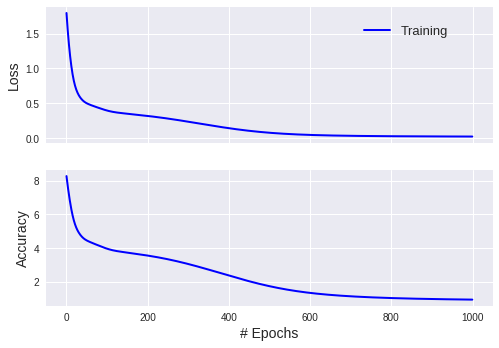

Test set metric (RMSE): 5.473407712971606


In [12]:
output_results(model_5, fitting_log_5, test_deviation_5)

What happens with a hidden layer with 100 nodes?

In [0]:
model_100, fitting_log_100, test_deviation_100 = run_model(train_X, train_Y, test_X, test_Y, 100, epochs=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_2 (RBFLayer)       (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[4.057537444168702e-05], [0.04010245596364748]]


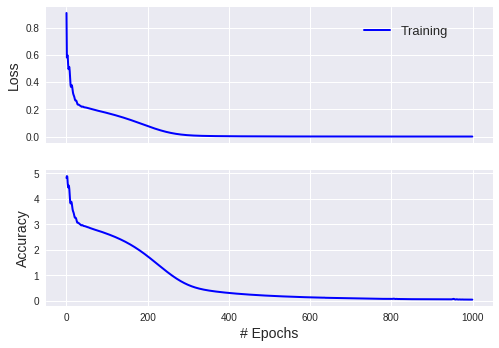

Test set metric (RMSE): 6.1616748829707815


In [14]:
output_results(model_100, fitting_log_100, test_deviation_100)

As the test metric is going up from the previous example with 5 nodes - we strongly suspect overfitting.  Try somewhere between 5 and 100 nodes on the hidden layer.

In [0]:
model_50, fitting_log_50, test_deviation_50 = run_model(train_X, train_Y, test_X, test_Y, 50, epochs=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_3 (RBFLayer)       (None, 50)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.0011114602675661445], [0.2104329715179053]]


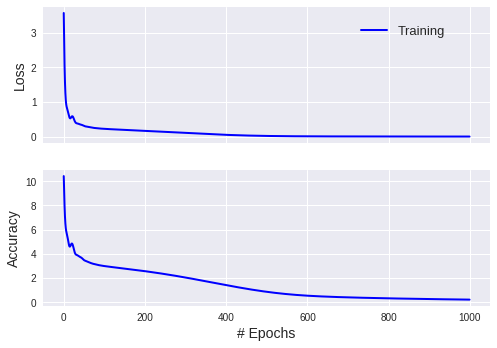

Test set metric (RMSE): 3.5142146806925783


In [16]:
output_results(model_50, fitting_log_50, test_deviation_50)

That is very good - both the training and testing metrics are less than the other versions we tried.